Author: Taylor Larkin \
Version Date: 2024-04-25

# Prediction Intervals via Conformal Inference

This AI Accelerator demonstrates various ways for generating prediction intervals for any DataRobot model. The methods presented here are rooted in the area of [conformal inference](https://arxiv.org/abs/1604.04173) (also known as [conformal prediction](https://arxiv.org/abs/2107.07511)). These types of approaches have become increasingly popular for uncertainty quantification because they do not require strict distributional assumptions to be met in order to achieve proper coverage (i.e., they only require that the testing data is exchangeable with the training data). While conformal inference can be applied across a wide array of prediction problems, the focus in this notebook will be prediction interval generation on regression targets. This notebook is formatted as follows:

1. Importing libraries
2. Notebook parameters and helper functions
3. Loading the example dataset
4. Modeling building and making predictions
5. Method 1: Absolute conformal
6. Method 2: Signed conformal
7. Method 3: Locally-weighted conformal 
8. Method 4: Conformalized quantile regression
9. Comparing methods
10. Conclusion

Note: the particulars for each method have been simplified (e.g., authors use an "adjusted" quantile level rather than the traditional quantile calculation implemented here). For a full treatment of each approach and specific algorithm details, see the cited reference papers below.

### 1. Importing libraries

[Read](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html) about different options for connecting to DataRobot from the client. Load the remaining libraries below in the usual way.

In [1]:
# Establish connection
import datarobot as dr

print(f"DataRobot version: {dr.__version__}")
dr.Client()

DataRobot version: 3.2.0


In [2]:
# Imports
import numpy as np
import pandas as pd
from datarobot.models.modeljob import wait_for_async_model_creation

### 2. Notebook parameters and helper functions

Below, you'll have two parameters for this notebook:

1. COVERAGE_LEVEL: fraction of prediction intervals that should contain the target
2. TEST_DATA_FRACTION: fraction of data to hold out and use as a testing dataset to evaluate each method

In addition, a couple functions are provided to make the following analysis easier - one of which computes the two metrics that will be used for comparison:

1. _Coverage_: fraction of computed prediction intervals that contain the target across all rows
2. _Average Width_: the average width of the prediction intervals across all rows

Here, a desirable method should achieve the proper coverage with the smallest width on average.

In [3]:
# Coverage level
COVERAGE_LEVEL = 0.9

# Fraction of data to use to evaluate each method
TEST_DATA_FRACTION = 0.2

In [4]:
# Helpers
def compute_coverage(
    y_test: np.array,
    y_lower: np.array,
    y_upper: np.array,
    significance: float,
    name: str = "",
) -> (float, float):
    """
    Computes coverage and average width
    Courtesy of https://github.com/yromano/cqr/blob/master/cqr/helper.py

    Parameters
    ----------
    y_test: true labels (n)
    y_lower: estimated lower bound for the labels (n)
    y_upper: estimated upper bound for the labels (n)
    significance: desired significance level
    name: optional output string (e.g. the method name)

    Returns
    -------
    coverage : average coverage
    avg_width : average width

    """
    # Compute coverage
    in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
    coverage = in_the_range / len(y_test) * 100
    print(
        "%s: Percentage in the range (expecting %.2f): %f"
        % (name, 100 - significance * 100, coverage)
    )

    # Compute average width
    avg_width = np.mean(abs(y_upper - y_lower))
    print("%s: Average width: %f" % (name, avg_width))

    return coverage, avg_width


def compute_training_predictions(model: dr.Model) -> pd.DataFrame:
    """
    Computes (or gathers) the out-of-sample training predictions from a model

    Parameters
    ----------
    model: DataRobot model

    Returns
    -------
    DataFrame of training predictions

    """

    # Get project to unlock holdout
    project = dr.Project.get(model.project_id)
    project.unlock_holdout()

    # Request or gather predictions
    try:

        training_predict_job = model.request_training_predictions(
            dr.enums.DATA_SUBSET.ALL
        )
        training_predictions = training_predict_job.get_result_when_complete()

    except dr.errors.ClientError:

        training_predictions = [
            tp
            for tp in dr.TrainingPredictions.list(project.id)
            if tp.model_id == model.id and tp.data_subset == "all"
        ][0]

    return training_predictions.get_all_as_dataframe()


def quantile_rearrangement(
    quantile_preds: pd.DataFrame,
    quantiles: [float],
) -> pd.DataFrame:
    """
    Produces monotonic values for rows that are non-monotonic
    Based on: https://github.com/yromano/cqr/blob/master/cqr/torch_models.py#L66-#L94

    Parameters
    ----------
    quantile_preds: dataframe of quantile predictions to rearrange, sorted from lowest quantile to highest
    quantiles: quantile values each column represents, sorted from lowest quantile to highest

    Returns
    -------
    Dataframe of rearranged quantile predictions

    References
    ----------
    Yaniv Romano, Evan Patterson, and Emmanuel J. Candes, “Conformalized quantile regression.” 2019.
    
    """

    # Copy
    df = quantile_preds.copy(deep=True)

    # Ensure we have enough columns and supplied quantile values
    assert df.shape[1] == len(
        quantiles
    ), "Need to have the same number of columns and quantiles values!"

    # Create a mask where True indicates the expected order is not met
    mask = (np.diff(df.values, axis=1) < 0).any(axis=1)

    # Extract those rows
    non_monotonic_rows = df[mask]

    # Rearrange the values via interpolation
    rearranged_rows = np.quantile(
        a=non_monotonic_rows.values, q=quantiles, method="linear", axis=1
    )

    # Update the original values with rearranged values
    df.loc[mask] = rearranged_rows.T

    return df

### 3. Loading the example dataset


The dataset you'll use comes from [this](https://www.datarobot.com/blog/solving-regression-problem-nba-player-performance/) DataRobot blog post. Each row represents a player in the National Basketball Association (NBA) and the columns signify different NBA statistics from various repositories, fantasy basketball news sources, and betting information. The target, `game_score`, is a single statistic that attempts to quantify player performance and productivity.

Additionally, you'll partition the data into a training and testing sets. The training set will be used for modeling building while the testing set will be used for evaluating each method.

In [5]:
# Load data
df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_NBA_2017-2018.csv"
)
df.head()

,roto_fpts_per_min,roto_minutes,roto_fpts,roto_value,free_throws_lag30_mean,field_goals_decay1_mean,game_score_lag30_mean,minutes_played_decay1_mean,PF_lastseason,free_throws_attempted_lag30_mean,...,team,opponent,over_under,eff_field_goal_percent_lastseason,spread_decay1_mean,position,OWS_lastseason,free_throws_percent_decay1,text_yesterday_and_today,game_score
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1,NaN,...,PHO,POR,NaN,0.475,NaN,SG,1.3,NaN,NaN,8.1
1,NaN,NaN,NaN,NaN,0.0,6.000000,8.10,27.066667,3.1,0.00,...,PHO,LAL,NaN,0.475,-48.000000,SG,1.3,NaN,NaN,18.6
2,NaN,NaN,NaN,NaN,1.5,8.000000,13.35,35.511111,3.1,2.50,...,PHO,LAC,NaN,0.475,-17.333333,SG,1.3,0.600000,NaN,5.4
3,NaN,NaN,NaN,NaN,2.0,6.285714,10.70,33.380952,3.1,3.00,...,PHO,SAC,NaN,0.475,-31.428571,SG,1.3,0.692308,NaN,16.5
4,NaN,NaN,NaN,NaN,2.5,7.200000,12.15,30.955556,3.1,3.25,...,PHO,UTA,NaN,0.475,-13.600000,SG,1.3,0.862069,NaN,8.4


<Axes: >

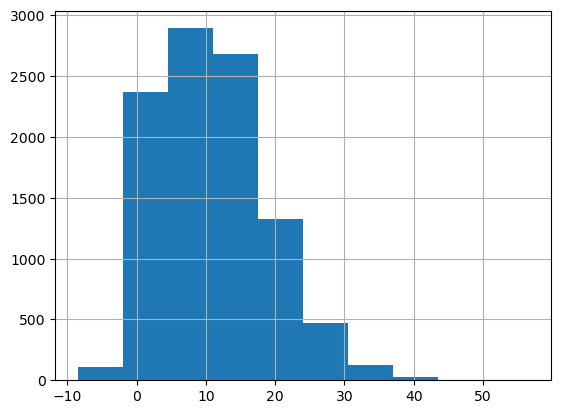

In [6]:
# Distribution of target
target_column = "game_score"
df[target_column].hist()

In [7]:
# Split data
df_train = df.sample(frac=1 - TEST_DATA_FRACTION, replace=False, random_state=10)
df_test = df.loc[~df.index.isin(df_train.index)]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
print(df_train.shape)
print(df_test.shape)

(7999, 52)
(2000, 52)


### 4. Modeling building and making predictions

To create a DataRobot project and start building models, you can use the convenient `Project.start` function, which chains together project creation, file upload, and target selection. Once models are finished training, you'll retrieve the one DataRobot recommends for deployment and request predictions for both the training and testing sets. Note that the predictions made on the training dataset are _not_ in-sample, but rather out-of-sample (i.e., also referred to as [stacked predictions](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/data-partitioning.html#)). These out-of-sample training predictions are a key component to each prediction interval method discussed in this notebook.

In [8]:
# Starting main project
project = dr.Project.start(
    sourcedata=df_train,
    project_name="Conformal Inference AIA - NBA",
    target=target_column,
    worker_count=-1,
)

# Unlock holdout set in order to train into it
project.unlock_holdout()

# Wait
project.wait_for_autopilot(check_interval=120)

In progress: 8, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 2s)
In progress: 8, queued: 0 (waited: 4s)
In progress: 8, queued: 0 (waited: 6s)
In progress: 8, queued: 0 (waited: 10s)
In progress: 8, queued: 0 (waited: 17s)
In progress: 8, queued: 0 (waited: 30s)
In progress: 7, queued: 0 (waited: 56s)
In progress: 1, queued: 0 (waited: 108s)
In progress: 6, queued: 0 (waited: 211s)
In progress: 0, queued: 0 (waited: 332s)
In progress: 1, queued: 0 (waited: 452s)
In progress: 0, queued: 0 (waited: 573s)
In progress: 0, queued: 0 (waited: 693s)


In [9]:
# Get recommended model
best_model = dr.ModelRecommendation.get(project.id).get_model()
best_model

Model('RandomForest Regressor')

In [10]:
# Compute training predictions (necessary for each method)
training_preds = compute_training_predictions(model=best_model)
training_preds.head()

,row_id,partition_id,prediction
0,0,0.0,0.899231
1,1,Holdout,9.240274
2,2,0.0,15.043815
3,3,4.0,8.626567
4,4,2.0,15.435130


In [11]:
# Request predictions on testing data
pred_dataset = project.upload_dataset(sourcedata=df_test, max_wait=60 * 60 * 24)
predict_job = best_model.request_predictions(dataset_id=pred_dataset.id)
testing_preds = predict_job.get_result_when_complete(max_wait=60 * 60 * 24)
testing_preds.head()

,row_id,prediction
0,0,14.275717
1,1,13.238045
2,2,12.827469
3,3,14.141054
4,4,7.113611


In [12]:
# Join predictions training and testing datasets
df_train = df_train.join(training_preds.set_index("row_id"))
df_test = df_test.join(testing_preds.set_index("row_id"))
display(df_train[[target_column, "prediction"]])
display(df_test[[target_column, "prediction"]])

,game_score,prediction
0,0.0,0.899231
1,0.0,9.240274
2,21.6,15.043815
3,4.4,8.626567
4,26.7,15.435130
...,...,...
7994,18.4,19.801230
7995,12.9,10.349299
7996,19.3,14.453104
7997,9.8,23.360390


,game_score,prediction
0,5.4,14.275717
1,16.5,13.238045
2,7.2,12.827469
3,23.8,14.141054
4,0.0,7.113611
...,...,...
1995,17.0,10.358305
1996,25.0,16.455246
1997,-1.2,4.356278
1998,15.7,14.503841


<Axes: >

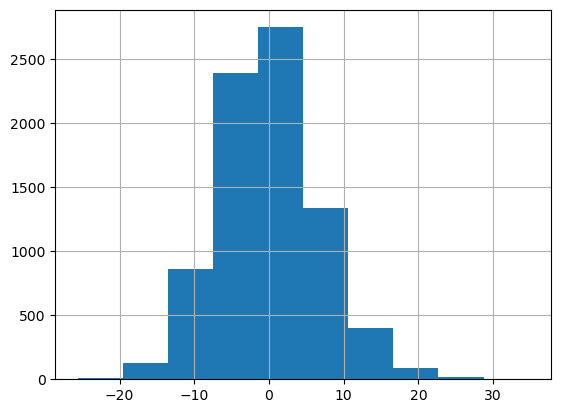

In [13]:
# Compute the residuals on the training data
df_train["residuals"] = df_train[target_column] - df_train["prediction"]
df_train["residuals"].hist()

### 5. Method 1: Absolute conformal

The first method you'll implement, regarded here as "absolute conformal," is as follows:

1. Take the absolute value of the out-of-sample residuals (these will be the conformity scores)
2. Compute the quantile associated with the specified COVERAGE_LEVEL on the conformity scores
3. Add and subtract this quantile value to the prediction

The resulting prediction intervals are guaranteed to be symmetric and the same width (since you're simply applying a scalar value across all rows). For more information regarding this approach, see [Section 2.3](https://www.diva-portal.org/smash/get/diva2:887891/FULLTEXT01.pdf).

In [14]:
# Compute the conformity scores
df_train["abs_residuals"] = df_train["residuals"].abs()
abs_residuals_q = df_train["abs_residuals"].quantile(COVERAGE_LEVEL)
abs_residuals_q

11.028431310477108

In [15]:
# Using the computed quantile, create the prediction intervals
df_test["method_1_lower"] = df_test["prediction"] - abs_residuals_q
df_test["method_1_upper"] = df_test["prediction"] + abs_residuals_q

In [16]:
# Compute metrics
method_1_coverage = compute_coverage(
    y_test=df_test[target_column].values,
    y_lower=df_test["method_1_lower"].values,
    y_upper=df_test["method_1_upper"].values,
    significance=1 - COVERAGE_LEVEL,
    name="Absolute Conformal",
)

Absolute Conformal: Percentage in the range (expecting 90.00): 89.000000
Absolute Conformal: Average width: 22.056863


### 6. Method 2: Signed conformal

"Signed conformal" follows a very similar procedure as the previous one:

1. Determine the lower and upper quantile levels based on the specified COVERAGE_LEVEL
2. Compute the lower and upper quantile values on the out-of-sample residuals (i.e., conformity scores)
3. Add these quantile values to the prediction

The main advantage to this approach over the previous one is that the prediction intervals are not forced to be symmetric, which can lead to better coverage for skewed targets. For more information regarding this approach, see [Section 3.2](https://www.diva-portal.org/smash/get/diva2:887891/FULLTEXT01.pdf).

In [17]:
# Compute lower and upper quantile levels to use based on the coverage
lower_coverage_q = round((1 - COVERAGE_LEVEL) / 2, 2)
upper_coverage_q = COVERAGE_LEVEL + (1 - COVERAGE_LEVEL) / 2
lower_coverage_q, upper_coverage_q

(0.05, 0.95)

In [18]:
# Compute quantiles on the conformity scores
residuals_q_low = df_train["residuals"].quantile(lower_coverage_q)
residuals_q_high = df_train["residuals"].quantile(upper_coverage_q)
residuals_q_low, residuals_q_high

(-10.573999229291612, 11.617478915155703)

In [19]:
# Using the quantile values, create the prediction intervals
df_test["method_2_lower"] = df_test["prediction"] + residuals_q_low
df_test["method_2_upper"] = df_test["prediction"] + residuals_q_high

In [20]:
# Compute metrics
method_2_coverage = compute_coverage(
    y_test=df_test[target_column].values,
    y_lower=df_test["method_2_lower"].values,
    y_upper=df_test["method_2_upper"].values,
    significance=1 - COVERAGE_LEVEL,
    name="Signed Conformal",
)

Signed Conformal: Percentage in the range (expecting 90.00): 88.900000
Signed Conformal: Average width: 22.191478


### 7. Method 3: Locally-weighted conformal

While the primary advantage of the previous two methods is their simplicity, the disadvantage is that each prediction interval ends up being the exact same width. In many cases, it's desirable to have varying widths that reflect the degree of confidence (i.e., harder to predict rows get a larger prediction interval and vice versa). To this end, you can make them more adaptive by using an auxiliary model to help augment the width on a per-row basis, depending on how much error we'd expect to see in a particular row. The "locally-weighted conformal" method is as follows:

1. Take the absolute value of the out-of-sample residuals
2. Build a model that regresses against the absolute residuals as the target using the same feature set
3. Compute the out-of-sample predictions from the absolute residuals model
4. Scale the out-of-sample residuals using the auxillary model's predictions to create the conformity scores
5. Compute the quantile associated with the specified COVERAGE_LEVEL on the conformity scores
6. Multiply this quantile value and the auxillary model's predictions together (this will result in a locally-weighted offset to apply, specific to each row)
7. Add and subtract this multiplied value to each prediction

Although this approach is more involved, it addresses the disadvantage above by making the prediction intervals adaptive to each row while still being symmetric. For more information regarding this approach, see [Section 5.2](https://arxiv.org/abs/1604.04173). 

In [21]:
# Starting project to predict absolute residuals
project_abs_residuals = dr.Project.start(
    sourcedata=df_train.drop(
        columns=[
            target_column,
            "partition_id",
            "prediction",
            "residuals",
        ],
        axis=1,
    ),
    project_name=f"Predicting absolute residuals from {project.project_name}",
    target="abs_residuals",
    worker_count=-1,
)
project_abs_residuals.wait_for_autopilot(check_interval=120)

In progress: 8, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 2s)
In progress: 8, queued: 0 (waited: 3s)
In progress: 8, queued: 0 (waited: 6s)
In progress: 8, queued: 0 (waited: 9s)
In progress: 8, queued: 0 (waited: 16s)
In progress: 8, queued: 0 (waited: 30s)
In progress: 7, queued: 0 (waited: 56s)
In progress: 1, queued: 0 (waited: 108s)
In progress: 6, queued: 0 (waited: 211s)
In progress: 0, queued: 0 (waited: 331s)
In progress: 1, queued: 0 (waited: 452s)
In progress: 0, queued: 0 (waited: 572s)
In progress: 0, queued: 0 (waited: 693s)


In [22]:
# Get recommended model
best_model_abs_residuals = dr.ModelRecommendation.get(
    project_abs_residuals.id
).get_model()
best_model_abs_residuals

Model('RandomForest Regressor')

In [23]:
# Compute training predictions and join
df_train = df_train.join(
    compute_training_predictions(model=best_model_abs_residuals)
    .rename(columns={"prediction": f"abs_residuals_prediction"})
    .set_index("row_id")
    .drop(columns=["partition_id"], axis=1)
)

In [24]:
# Now compute predictions on testing data and join
pred_dataset_abs_residuals = project_abs_residuals.upload_dataset(
    sourcedata=df_test, max_wait=60 * 60 * 24
)
df_test = df_test.join(
    best_model_abs_residuals.request_predictions(
        dataset_id=pred_dataset_abs_residuals.id
    )
    .get_result_when_complete(max_wait=60 * 60 * 24)
    .rename(columns={"prediction": f"abs_residuals_prediction"})
    .set_index("row_id")
)

In [25]:
# Now we need to compute our locally-weighted conformity scores and take the quantile
scaled_abs_residuals = df_train["abs_residuals"] / df_train["abs_residuals_prediction"]
scaled_abs_residuals_q = scaled_abs_residuals.quantile(COVERAGE_LEVEL)
scaled_abs_residuals_q

2.0517307447009157

In [26]:
# Using the quantile value and absolute residuals model, create the prediction intervals
df_test["method_3_lower"] = (
    df_test["prediction"] - df_test["abs_residuals_prediction"] * scaled_abs_residuals_q
)
df_test["method_3_upper"] = (
    df_test["prediction"] + df_test["abs_residuals_prediction"] * scaled_abs_residuals_q
)

In [27]:
# Compute metrics
method_3_coverage = compute_coverage(
    y_test=df_test[target_column].values,
    y_lower=df_test["method_3_lower"].values,
    y_upper=df_test["method_3_upper"].values,
    significance=1 - COVERAGE_LEVEL,
    name="Locally-Weighted Conformal",
)

Locally-Weighted Conformal: Percentage in the range (expecting 90.00): 89.800000
Locally-Weighted Conformal: Average width: 21.710734


### 8. Method 4: Conformalized Quantile Regression

If you consider "locally-weighted conformal" to be a model-based extension of "absolute conformal," then you could consider "conformalized quantile regression" to be a model-based extension of "signed conformal." The goal is similar: create more adaptive prediction intervals. However, it inherits the quality that the prediction intervals are not forced to be symmetric. The [reference paper](https://arxiv.org/abs/1905.03222) offers a symmetric and asymmetric formulation for the conformity scores. The former (Theorem 1) "allows coverage errors to be spread arbitrarily over the left and right tails" while the latter (Theorem 2) controls "the left and right tails independently, resulting in a stronger coverage guarantee" at the cost of slightly wider prediction intervals. Here, you'll use the symmetric version. The full method is as follows:

1. Determine the lower and upper quantile levels based on the specified COVERAGE_LEVEL
2. Train two quantile regression models at the lower and upper quantile levels, respectively, using the training set
3. Compute the out-of-sample predictions for both quantile models
4. Compute the conformity scores, $E$, such that $E = max[\hat{q}_{lower} - y, y - \hat{q}_{upper}]$ where $y$ is the target, $\hat{q}_{lower}$ is the lower quantile predictions, and $\hat{q}_{upper}$ is the upper quantile predictions
4. Compute the quantile associated with the specified COVERAGE_LEVEL on $E$
5. Add and subtract this quantile value to the quantile predictions

Notably, this approach is completely independent of your main model. That is, it doesn't use any information about the initial recommended model defined earlier. This may or may not be desired, depending on the user's preference or use case requirements. To ensure the main model's predictions fall within its respective prediction interval, you'll simply extend the interval's boundary to be equal to the prediction itself (if the prediction lies outside of the respective prediction interval that is). Additionally, it's possible to experience quantile crossing (i.e., lower quantile predictions being greater than higher quantile predictions and vice versa for a given row of data). To combat this, the referenced paper offers a solution via rearrangement. A simplified version of this is implemented here.

There are two ways to run quantile regression models in DataRobot:

1. [Set the project metric to quantile loss](https://docs.datarobot.com/en/docs/modeling/automl-preview/quantile-reg.html) (which is currently a public-preview feature)
2. Use DataRobot blueprints with algorithms that support quantile loss as a hyperparameter in your current project. These includes gradient boosted trees from scikit-learn and Keras neural networks.

In this notebook, you'll use the second approach, since it's generally available. This involves using DataRobot's [advanced tuning](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/adv-tuning.html#advanced-tuning) functionality to change the loss function to the desired quantile loss.

In [28]:
# Get a GBT from scikit-learn
models = project.get_models()
gbt_models = [x for x in models if x.model_type.startswith("Gradient Boosted")]

# Check for GBT model. If none, make one.
if gbt_models:

    # Get most accurate one on validation set
    gbt_model = gbt_models[0]

    # Make sure it's training on all the data
    if gbt_model.sample_pct < 100:

        # Train it on all the data
        model_job_id = gbt_model.retrain(
            sample_pct=100,
            featurelist_id=gbt_model.featurelist_id,
        )
        gbt_model = wait_for_async_model_creation(
            project_id=project.id, model_job_id=model_job_id, max_wait=60 * 60 * 24
        )

else:

    # Pull models (will usually be at least one blueprint with a scikit-learn GBT)
    gbt_bps = [
        x
        for x in project.get_blueprints()
        if x.model_type.startswith("Gradient Boosted")
    ]

    # Get first one
    gbt_bp = gbt_bps[0]

    # Train it on all the data
    gbt_model = wait_for_async_model_creation(
        project_id=project.id,
        model_job_id=project.train(gbt_bp, sample_pct=100),
        max_wait=60 * 60 * 24,
    )

gbt_model

Model('Gradient Boosted Greedy Trees Regressor with Early Stopping (Least-Squares Loss)')

In [29]:
# Train quantile models
quantile_models = {lower_coverage_q: None, upper_coverage_q: None}

# Tune main keras model
for q in quantile_models.keys():

    # Start
    tune = gbt_model.start_advanced_tuning_session()

    # Set loss and level
    tune.set_parameter(
        task_name=gbt_model.model_type, parameter_name="loss", value="quantile"
    )
    tune.set_parameter(task_name=gbt_model.model_type, parameter_name="alpha", value=q)

    # Save job
    quantile_models[q] = tune.run()

# Wait and get resulting models
for q in quantile_models.keys():

    quantile_models[q] = quantile_models[q].get_result_when_complete(
        max_wait=60 * 60 * 24
    )

quantile_models

{0.05: Model('Gradient Boosted Greedy Trees Regressor with Early Stopping (Quantile Loss)'),
 0.95: Model('Gradient Boosted Greedy Trees Regressor with Early Stopping (Quantile Loss)')}

In [30]:
# Compute training predictions
for q in quantile_models.keys():

    df_train = df_train.join(
        compute_training_predictions(model=quantile_models[q])
        .rename(columns={"prediction": f"quantile_prediction_{q}"})
        .set_index("row_id")
        .drop(columns=["partition_id"], axis=1)
    )

# Check
df_train[
    [
        target_column,
        f"quantile_prediction_{lower_coverage_q}",
        f"quantile_prediction_{upper_coverage_q}",
    ]
]

,game_score,quantile_prediction_0.05,quantile_prediction_0.95
0,0.0,-0.661701,7.367953
1,0.0,-0.109510,16.625219
2,21.6,3.752373,24.534147
3,4.4,0.521447,18.209039
4,26.7,1.367213,26.972765
...,...,...,...
7994,18.4,4.882632,35.834840
7995,12.9,0.879488,18.311118
7996,19.3,1.235300,23.512004
7997,9.8,5.622114,32.164047


In [31]:
# Making prediction on test data
quantile_models_test_predict = quantile_models.copy()
for q in quantile_models.keys():

    quantile_models_test_predict[q] = quantile_models[q].request_predictions(
        dataset_id=pred_dataset.id
    )

# Joining the results
for q in quantile_models.keys():

    df_test = df_test.join(
        quantile_models_test_predict[q]
        .get_result_when_complete(max_wait=60 * 60 * 24)
        .rename(columns={"prediction": f"quantile_prediction_{q}"})
        .set_index("row_id")
    )

# Check
df_test[
    [
        target_column,
        f"quantile_prediction_{lower_coverage_q}",
        f"quantile_prediction_{upper_coverage_q}",
    ]
]

,game_score,quantile_prediction_0.05,quantile_prediction_0.95
0,5.4,0.918277,25.233671
1,16.5,1.488291,25.160815
2,7.2,0.315117,24.488930
3,23.8,0.864427,23.131123
4,0.0,0.239838,21.055298
...,...,...,...
1995,17.0,-0.113189,23.151948
1996,25.0,5.386518,23.425884
1997,-1.2,-1.631877,22.678644
1998,15.7,2.107615,23.573162


In [32]:
# Implement quantile rearrangement
q_crossing_train = (
    df_train[f"quantile_prediction_{lower_coverage_q}"]
    > df_train[f"quantile_prediction_{upper_coverage_q}"]
).sum()
q_crossing_test = (
    df_test[f"quantile_prediction_{lower_coverage_q}"]
    > df_test[f"quantile_prediction_{upper_coverage_q}"]
).sum()
print(
    f"Number of rows with quantile crossing in training set (before rearrangement): {q_crossing_train}"
)
print(
    f"Number of rows with quantile crossing in testing set (before rearrangement): {q_crossing_test}"
)

# Capture quantile columns
quantile_pred_cols = [x for x in df_train.columns if x.startswith("quantile")]

# On training set
df_train = df_train.drop(quantile_pred_cols, axis=1).join(
    quantile_rearrangement(
        quantile_preds=df_train[
            [
                f"quantile_prediction_{lower_coverage_q}",
                f"quantile_prediction_{upper_coverage_q}",
            ]
        ],
        quantiles=[lower_coverage_q, upper_coverage_q],
    )
)

# On testing set
df_test = df_test.drop(quantile_pred_cols, axis=1).join(
    quantile_rearrangement(
        quantile_preds=df_test[
            [
                f"quantile_prediction_{lower_coverage_q}",
                f"quantile_prediction_{upper_coverage_q}",
            ]
        ],
        quantiles=[lower_coverage_q, upper_coverage_q],
    )
)

# Check again
q_crossing_train = (
    df_train[f"quantile_prediction_{lower_coverage_q}"]
    > df_train[f"quantile_prediction_{upper_coverage_q}"]
).sum()
q_crossing_test = (
    df_test[f"quantile_prediction_{lower_coverage_q}"]
    > df_test[f"quantile_prediction_{upper_coverage_q}"]
).sum()
print(
    f"Number of rows with quantile crossing in training set (after rearrangement): {q_crossing_train}"
)
print(
    f"Number of rows with quantile crossing in testing set (after rearrangement): {q_crossing_test}"
)

Number of rows with quantile crossing in training set (before rearrangement): 7
Number of rows with quantile crossing in testing set (before rearrangement): 2
Number of rows with quantile crossing in training set (after rearrangement): 0
Number of rows with quantile crossing in testing set (after rearrangement): 0


In [33]:
# Now we compute our conformity scores and take the quantile
E_cqr = np.maximum(
    df_train[f"quantile_prediction_{lower_coverage_q}"] - df_train[target_column],
    df_train[target_column] - df_train[f"quantile_prediction_{upper_coverage_q}"],
)
E_cqr_q = E_cqr.quantile(COVERAGE_LEVEL)
E_cqr_q

0.9252244694652537

In [34]:
# Create the prediction intervals
df_test["method_4_lower"] = df_test[f"quantile_prediction_{lower_coverage_q}"] - E_cqr_q
df_test["method_4_upper"] = df_test[f"quantile_prediction_{upper_coverage_q}"] + E_cqr_q

In [35]:
# Extend to make sure the prediction is inside the interval
df_test["method_4_lower"] = df_test[["method_4_lower", "prediction"]].min(axis=1)
df_test["method_4_upper"] = df_test[["method_4_upper", "prediction"]].max(axis=1)

In [36]:
# Compute metrics
method_4_coverage = compute_coverage(
    y_test=df_test[target_column].values,
    y_lower=df_test["method_4_lower"].values,
    y_upper=df_test["method_4_upper"].values,
    significance=1 - COVERAGE_LEVEL,
    name="Conformalized Quantile Regression",
)

Conformalized Quantile Regression: Percentage in the range (expecting 90.00): 89.650000
Conformalized Quantile Regression: Average width: 21.743307


### 9. Comparing methods

Below you can see that the more advanced methods (i.e., "locally-weighted conformal" and "conformalized quantile regression") yield similar coverage rates while producing smaller prediction intervals on average. Notably, this is just one dataset, and it's suggested to empirically experiment with your own data to find the best method for your use case.

In [37]:
# Organize
summary = pd.DataFrame(
    {
        "Coverage": [
            method_1_coverage[0],
            method_2_coverage[0],
            method_3_coverage[0],
            method_4_coverage[0],
        ],
        "Average Width": [
            method_1_coverage[1],
            method_2_coverage[1],
            method_3_coverage[1],
            method_4_coverage[1],
        ],
        "Method": [
            "Absolute Conformal",
            "Signed Conformal",
            "Locally-Weighted Conformal",
            "Conformalized Quantile Regression",
        ],
    }
)
summary

,Coverage,Average Width,Method
0,89.00,22.056863,Absolute Conformal
1,88.90,22.191478,Signed Conformal
2,89.80,21.710734,Locally-Weighted Conformal
3,89.65,21.743307,Conformalized Quantile Regression


### 10. Conclusion

This notebook demonstrates how one could build prediction intervals for any DataRobot model using methods derived from the conformal inference space. Conformal inference is a popular framework to use for generating such prediction intervals because they don't require strict distributional assumptions to achieve the desired coverage, so long as the testing data is exchangeable with the training data. This characteristic was confirmed in the analysis done here. Because each approach offers different pros and cons, it's worthwhile to use this AI Accelerator as a starting point for your own experiments to decide which one to implement for your use case. DataRobot offers the ability to easily implement each of these methods, even for the more advanced techniques. For more information on the topic of conformal inference, see the following [introductory paper](https://arxiv.org/abs/2107.07511).